In [1]:
# Import the library
import os
import rasterio
from rasterio import plot
from rasterio.plot import show  # display images
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # Mathematical python module
from osgeo import gdal 
import fiona
import pandas as pd
import geopandas as gpd
import utm

import xarray  # Data storage/format 
from IPython.display import Markdown  # Nicer display
import folium  # Display
#from eodag import EODataAccessGateway  # Query data catalog
from ipyleaflet import Map, basemaps, LayersControl  # Display
#from qgislab import qgislab  # Display

In [2]:
# Define the directory for the work
os.chdir("/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/WH_Model")
datapath = "/Users/metogbedjihouessi/Documents/EO-Africa/"

In [3]:
###*************************
# Convert ground observation csv data into shapefile
###*************************

In [4]:
# Opening the CSV file
WhObsPoint = pd.read_csv(datapath+'/Livrables/Water_Hyacinth_Data.csv', header=0)
#print(WhObsPoint)

In [5]:
# Create the shapefile and iterate over each row in the dataframe and save record

# Define schema
schema = {
    'geometry':'Point',
    'properties':[('Date','str'), ('Place','str'), ('ID1','str'), ('ID2','str'),
                  ('Density','float'), ('Biomasse', 'float'), ('Plant_length', 'float'), ('Comments','str')]
}

# Open a fiona object
WhObsPointShp = fiona.open(datapath+'/Algorithm/WH_Model/WH_NkePoints.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:32631")

# Iterate over each row in the dataframe and save record
for index, row in WhObsPoint.iterrows():
    rowDict = {
        'geometry': {'type': 'Point',
                     'coordinates': (row.easting,row.northing)},
        'properties': {'Date': row.DATE,
                       'Place': row.Place_Name,
                       'ID1': row.ID1,
                       'ID2': row.ID2,
                       'Density': row.Density,
                       'Biomasse': row.Biomasse,
                       'Plant_length': row.Plant_length,
                       'Comments': row.Comments,
                      }
    }
    WhObsPointShp.write(rowDict)
#close fiona object
WhObsPointShp.close()       

EPSG:32631


<Axes: >

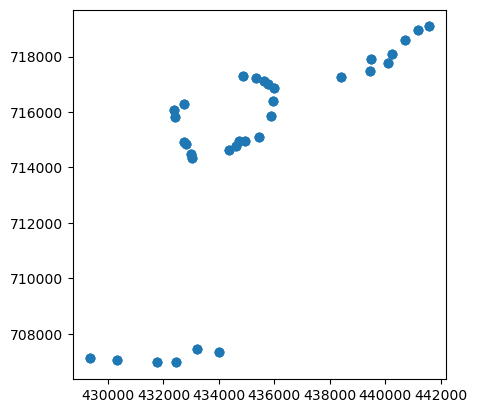

In [6]:
# Open the shapefile 
WH_GroundPoint = gpd.read_file(datapath+'/Algorithm/WH_Model/WH_NkePoints.shp')
print(WH_GroundPoint.crs)
WH_GroundPoint.plot()

In [69]:
###*************************
# NVDI Calculation for the image of 17 December 2017
###*************************

In [7]:
# Cropping the images to lake nokoue shape
inputPath = "/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/"
outputPath = "/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/"

# To select the tif files
bandlist = [band for band in os.listdir(inputPath) if band[-5:]=='m.jp2']

#To define the location of the shapefile to be used for clipping
shp_clip = "/Users/metogbedjihouessi/Documents/Djihouessi/My Documents/IHE-2016/Msc_Research/Images_Classification/2016_12/2016_12_12/Nokoue_Shp/Nokoué.shp"

#To clip multiple raster
for band in bandlist:
    print(outputPath + band[:-4] + '_clip_Nke' + band[-4:])
    options = gdal.WarpOptions(cutlineDSName = shp_clip, cropToCutline = True)
    outBand = gdal.Warp(srcDSOrSrcDSTab = inputPath+band,
                        destNameOrDestDS = outputPath+band[:-4]+'_clip_Nke'+band[-4:],
                        options = options)
    outBand = None

/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T100411_AOT_10m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T100411_B04_10m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T100411_TCI_10m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T100411_WVP_10m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T100411_B02_10m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/201912/L2A_T31NDH_A023428_20191217T101304/IMG_DATA/R10m/T31NDH_20191217T10

In [8]:
# Import the images from a directory
imagePath = inputPath
band4 = rasterio.open(imagePath+'T31NDH_20191217T100411_B04_10m_clip_Nke.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open(imagePath+'T31NDH_20191217T100411_B08_10m_clip_Nke.jp2', driver='JP2OpenJPEG') #nir

#Converting and Remaning bands for NDVI calculation
red = band4.read(1).astype('float32')
nir = band8.read(1).astype('float32')


In [9]:
#NDVI calculation as a matrix

ndvi = np.divide((nir - red), (nir + red), 
                          out=np.zeros_like(red), where=(nir + red) != 0)

# Another way to calculate it 
#np.seterr(divide='ignore', invalid='ignore')
#ndvi = np.where(
#    (nir+red)==0.,
#    0,
#    (nir-red)/(nir+red)
#)
#ndvi

In [10]:
# Transforming the NDVI matrix to raster image
ndviImage = rasterio.open(datapath+'/Algorithm/WH_Model/ndviImage.tiff', 'w', driver='Gtiff',
                          width = band4.width,
                          height = band4.height,
                          count = 1,
                          crs = band4.crs,
                          transform = band4.transform,
                          dtype='float64'
                         )
ndviImage.write(ndvi, 1)
ndviImage.close()

In [12]:
# Plotting the NDVI Image
#ndvi20191217 = rasterio.open(datapath+'/Algorithm/WH_Model/ndviImage_20191217.tiff')
#plot.show(ndvi20191217)

In [13]:
# Clip a raster with as shapefile 
#inputPath = datapath+'/Algorithm/WH_Model/'
#outputPath = datapath+'/Algorithm/WH_Model/'
#shp_clip = datapath+'/Algorithm/SHP_Nokoue/Nokoué.shp'
#options = gdal.WarpOptions(cutlineDSName = shp_clip, cropToCutline = True)
#outBand = gdal.Warp(srcDSOrSrcDSTab = datapath+'/Algorithm/WH_Model/ndviImage_20191217.tiff',
#                        destNameOrDestDS = datapath+'/Algorithm/WH_Model/ndviImage_20191217.tiff'[:-5]+'_to_Nke.tiff',
#                        options = options)
#outBand = None

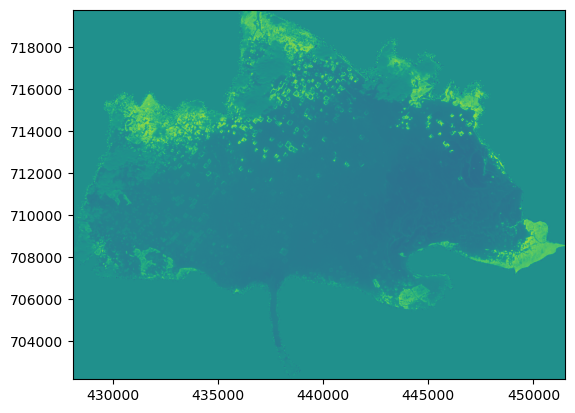

<Axes: >

In [14]:
# Plotting the NDVI Image
ndvi = rasterio.open(datapath+'/Algorithm/WH_Model/ndviImage.tiff')
plot.show(ndvi)

In [15]:
#max_ndvi = np.float64(max(ndvi[0]))
#min_ndvi = np.float64(min(ndvi[0]))
#max_ndvi, min_ndvi

<Axes: >

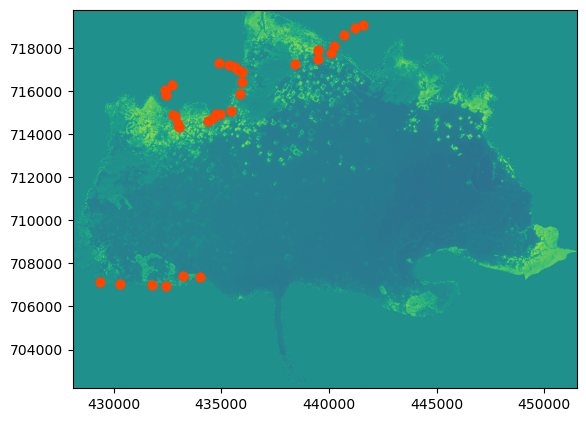

In [16]:
# Show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(6.5,6.5))
WH_GroundPoint.plot(ax=ax, color='orangered')
plot.show(ndvi, ax=ax)

In [17]:
values = pd.Series()

# Read input shapefile with fiona and iterate over each feature
with fiona.open(datapath+'/Algorithm/WH_Model/WH_NkePoints.shp') as shp:
    for feature in shp:
        station_name = feature['properties']['ID2']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rasterio.open(datapath+'/Algorithm/WH_Model/ndviImage.tiff') as src:
            value = [v for v in src.sample([coords])][0][0]
        # Update the pandas serie accordingly
        values.loc[station_name] = value

# Write records into a CSV file
values.to_csv('ndvi.csv')
data_ndvi = pd.read_csv('ndvi.csv')
data_ndvi.columns.values[0] = "Station"
data_ndvi.columns.values[1] = "ndvi"
data_ndvi.to_csv('ndvi.csv')